In [6]:
#Extração e Conversão para PNG
import zipfile
import os
import cv2
import numpy as np


#Relacionado a Modelos
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

#Plot do Grafico e Imagens
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random.seed(42)



In [7]:
# Extraír o zip
if not os.path.exists("./cats_vs_dogs/"):
  with zipfile.ZipFile("./cats_vs_dogs.zip", "r") as zip_ref:
      zip_ref.extractall("./cats_vs_dogs/")

  print("Zip Extraído")
else:
  print("Pasta extraída já existe")

Pasta extraída já existe


In [8]:
if not os.path.exists("./cats_vs_dogs_png/"):
  for root, _, files in os.walk("./cats_vs_dogs/"):
      rel_path = os.path.relpath(root, "./cats_vs_dogs/")
      out_folder = os.path.join("./cats_vs_dogs_png/", rel_path)
      os.makedirs(out_folder, exist_ok=True)

      for file in files:
          if file.lower().endswith(".jpg"):
              src_path = os.path.join(root, file)
              dst_file = os.path.splitext(file)[0] + ".png"
              dst_path = os.path.join(out_folder, dst_file)

              # Conversão
              img = cv2.imread(src_path)
              if img is None:
                  continue

              cv2.imwrite(dst_path, img)

  print("Pasta Criada")
else:
  print("Pasta png ja existe")

Pasta png ja existe


In [76]:
TAMANHO_IMG = (128, 128)
TAMANHO_BATCH = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./cats_vs_dogs_png/archive/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=TAMANHO_IMG,
    batch_size=TAMANHO_BATCH,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "./cats_vs_dogs_png/archive/",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=TAMANHO_IMG,
    batch_size=TAMANHO_BATCH,
    label_mode="binary"
)

train_ds = train_ds.shuffle(len(train_ds)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

for images, labels in train_ds.take(1):
    print("Shape das Imagens:", images.shape)
    print("Exemplo de Labels:", labels.numpy().T)

print("Train:", len(train_ds)*TAMANHO_BATCH)
print("Val:", len(val_ds)*TAMANHO_BATCH)

Found 24997 files belonging to 2 classes.
Using 19998 files for training.
Found 24997 files belonging to 2 classes.
Using 4999 files for validation.
Shape das Imagens: (32, 128, 128, 3)
Exemplo de Labels: [[1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.
  1. 1. 0. 0. 0. 0. 1. 1.]]
Train: 20000
Val: 5024


In [10]:
def model(input_shape=(TAMANHO_IMG[0], TAMANHO_IMG[1], 3)):
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    preprocess = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
        layers.Lambda(preprocess_input)
    ])

    model = Sequential([
        layers.Input(shape=input_shape),
        preprocess,
        base_model,
        layers.GlobalAveragePooling2D(),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Dense(1, activation="sigmoid")
    ])

    model.base_model = base_model

    return model


In [70]:
# Treinar Modelo
def train_model(model, train_ds, val_ds):
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    
    model.compile(
        optimizer=Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[early_stop],
    )

    return history


# Grafico
def plot_combined_history(history_antes, history_depois):
    # --- Loss ---
    loss = history_antes.history['loss']
    val_loss = history_antes.history['val_loss']
    
    epocas_antes = len(history_antes.history['loss'])
    
    loss.extend(history_depois.history['loss'])
    val_loss.extend(history_depois.history['val_loss'])
    
    # --- Accuracy ---
    acc = history_antes.history['accuracy']
    val_acc = history_antes.history['val_accuracy']
    
    acc.extend(history_depois.history['accuracy'])
    val_acc.extend(history_depois.history['val_accuracy'])
    
    # --- Figura com 2 gráficos lado a lado ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axs[0].plot(loss, label='Treino')
    axs[0].plot(val_loss, label='Validação')
    axs[0].axvline(epocas_antes, color='green', linestyle='--', label='Início do Fine-Tuning')
    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss do Modelo')
    axs[0].legend()
    
    # Accuracy
    axs[1].plot(acc, label='Treino')
    axs[1].plot(val_acc, label='Validação')
    axs[1].axvline(epocas_antes, color='green', linestyle='--', label='Início do Fine-Tuning')
    
    # Destaque da precisão máxima
    max_val_acc = max(val_acc)
    max_val_epoch = val_acc.index(max_val_acc)
    axs[1].scatter(max_val_epoch, max_val_acc, color='red', zorder=5)
    axs[1].text(max_val_epoch, max_val_acc + 0.01, f"{max_val_acc:.4f}", color='red', fontsize=10, ha='center')
    
    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Precisão do Modelo')
    axs[1].legend()
    
    plt.tight_layout()
    plt.savefig("grafico_modelo_com_accuracy.png")
    plt.show()
    
    # Imprimir máximos
    acc_train_antes = max(history_antes.history['accuracy'])
    acc_val_antes = max(history_antes.history['val_accuracy'])
    acc_train_depois = max(history_depois.history['accuracy'])
    acc_val_depois = max(history_depois.history['val_accuracy'])

    print(f"Precisão antes do Fine-Tuning: Treino = {acc_train_antes:.4f}, Validação = {acc_val_antes:.4f}")
    print(f"Precisão depois do Fine-Tuning: Treino = {acc_train_depois:.4f}, Validação = {acc_val_depois:.4f}")

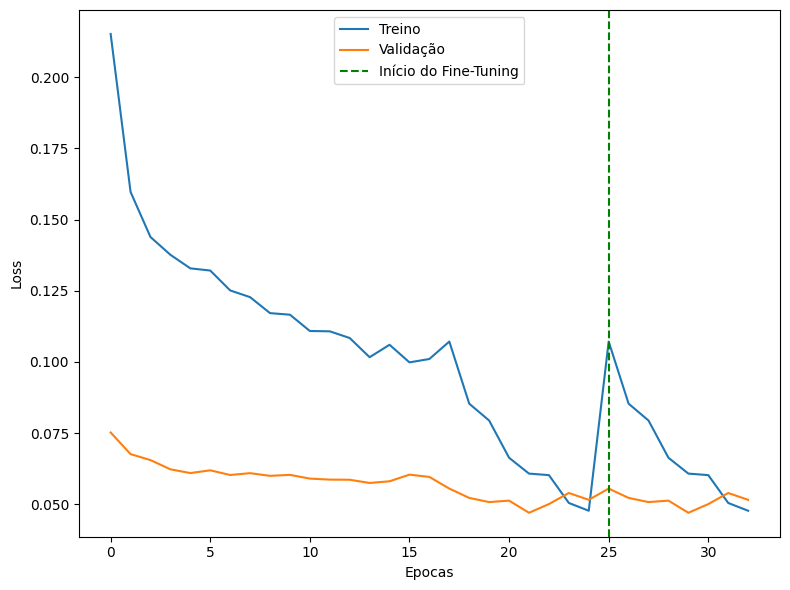

Precisão antes do Fine-Tuning: Treino = 0.9610, Validação = 0.9782
Precisão depois do Fine-Tuning: Treino = 0.9818, Validação = 0.9830


In [71]:
def treinar_modelo():
    if not os.path.exists("./modelo.keras"):
        model_enet = model()
        model_enet.summary()
        
        history = train_model(model_enet, train_ds, val_ds)
        
        for layer in model_enet.base_model.layers[-30:]:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
        
        history2 = train_model(model_enet, train_ds, val_ds)
        
        plot_combined_history(history, history2)
        model_enet.save("modelo.keras")
    else:
        model_enet = keras.models.load_model("modelo.keras")
        img = mpimg.imread("grafico_modelo.png")
        plt.imshow(img)
        plt.axis("off")
        plt.show()


/tmp/ipykernel_1152964/3830300016.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels.numpy())


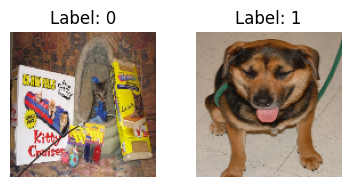

In [24]:
num_classes = 2

examples_per_class = {}

# Loop through the dataset until we have one example per class
for images, labels in train_ds.unbatch():
    label = int(labels.numpy())
    if label not in examples_per_class:
        examples_per_class[label] = images
    if len(examples_per_class) == num_classes:
        break

# Plot one example per class
plt.figure(figsize=(15, 10))
for i in range(num_classes):
    img = examples_per_class[i]
    plt.subplot(6, 8, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Label: {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [72]:
# Predict de uma imagem
def predict_image(model, img_array):
    img_array = preprocess_input(img_array)  # pré-processamento correto
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)[0][0]

    class_names = ['Cat', 'Dog']  # ajuste se necessário

    if pred < 0.5:
        return class_names[0], float(1 - pred)
    else:
        return class_names[1], float(pred)


def testar_modelo(model, n_imagens=2):
    arquivos = [f for f in os.listdir("./teste") if f.lower().endswith(".png")]
    imagens_escolhidas = random.sample(arquivos, n_imagens)

    plt.figure(figsize=(20, 5))

    for i, nome in enumerate(imagens_escolhidas):
        caminho = os.path.join("./teste", nome)

        # Carregar imagem
        img = tf.keras.utils.load_img(caminho, target_size=TAMANHO_IMG)
        img_array = tf.keras.utils.img_to_array(img)

        # Obter predição
        classe, confianca = predict_image(model, img_array)

        # Mostrar imagem
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_array.astype("uint8"))
        plt.title(f"{classe}\nConf: {confianca:.2f}")
        plt.axis("off")

    plt.show()

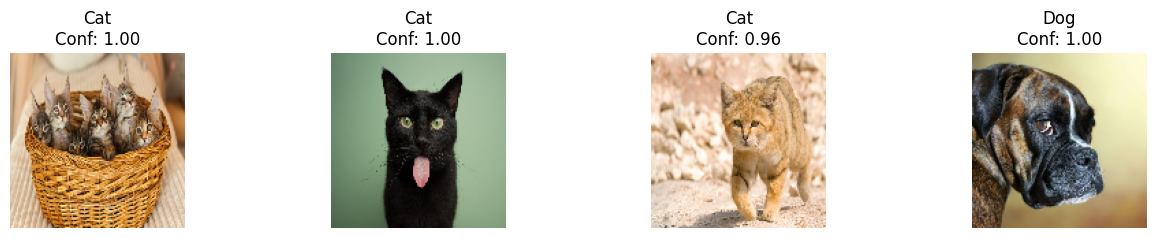

In [79]:
testar_modelo(model_enet, 4)
